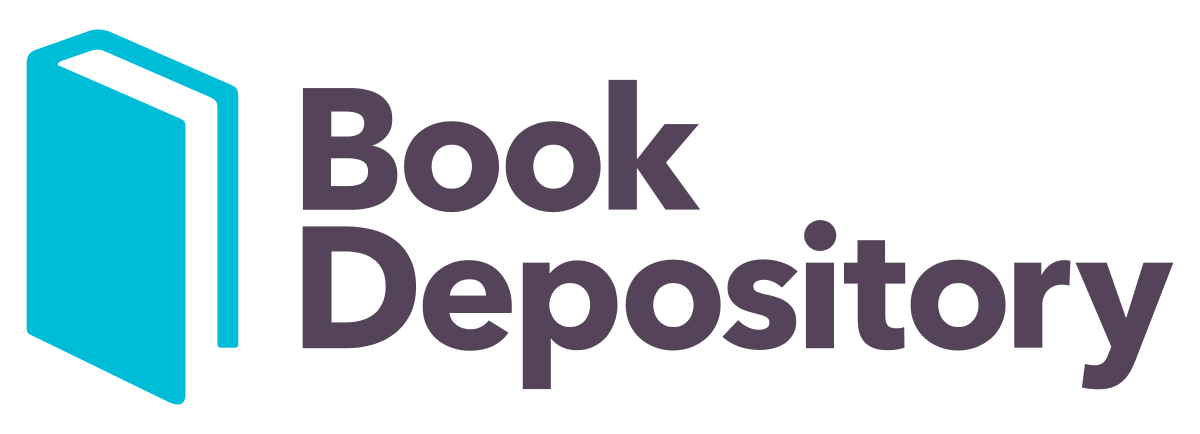

# Libraries

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas
import typing
import time
import random
import re #regex

# Data source

In [3]:
#Number of pages to crawl each page contain 30 books
NUMBER_OF_PAGES = 300
#first page
URL = 'https://www.bookdepository.com/search?searchLang=123&page=1' 

# Creating a soup object by url address

In [4]:
def get_soup_object(url: str) -> BeautifulSoup:
    while True:
        try:
            request: requests = requests.get(url)
            if request.ok:
                break 
        except:
            time.sleep(random.randrange(1,4))
            
            
    return BeautifulSoup(request.content, 'lxml')

# Book properties functions

In [5]:
#properties combined with exception handling 

#will be deleted after cleaning duplicates
def get_title(soup_object: BeautifulSoup) -> str:
    title: str = ''
    try:
        title = soup_object.find('h1', {'itemprop': 'name'}).text.strip()
    except:
        return None
    return title


def get_pages_count(soup_object: BeautifulSoup) -> int:
    pages_count: int = 0
    pages_count_string: str = ''
    try:
        pages_count_string = soup_object.find('span', {'itemprop': 'numberOfPages'}).text.strip()
        pages_count = int(re.findall('\d+', pages_count_string)[0])
    except:
        return None
    return pages_count


def get_date_published(soup_object: BeautifulSoup) -> str:
    date_published: str = ''
    try:
        date_published = soup_object.find('span', {'itemprop': 'datePublished'}).text.strip()
    except:
        return None
    return date_published


def get_best_seller_rank(soup_object: BeautifulSoup) -> int:
    best_seller_rank: int = 0
    try:
        biblio_info_class: BeautifulSoup = soup_object.find('ul', {'class':'biblio-info'})
        best_seller_rank = int(biblio_info_class('li')[-1].find('span').text.strip().replace(',',''))
    except:
        return None
    return best_seller_rank


def get_rating(soup_object: BeautifulSoup) -> float:
    book_rating: int = 0
    book_rating_str: str = ''
    try:
        book_rating_str = soup_object.find('span', {'itemprop': 'ratingValue'}).text.strip()
        book_rating = float(book_rating_str)
    except:
        return None
    return book_rating


def get_rating_count(soup_object: BeautifulSoup) -> int:
    rating_count: int = 0
    try:
        rating_count = int(soup_object.find('meta', {'itemprop': 'ratingCount'})['content'])
    except:
        return None
    return rating_count


def get_author(soup_object: BeautifulSoup) -> str:
    author: str = ''
    try:
        author = soup_object.find('span', {'itemprop': 'name'}).text.strip()
    except:
        return None
    return author


def get_backtype(soup_object: BeautifulSoup) -> str:
    backtype: str = ''
    try:
        backtype_ul: BeautifulSoup = soup_object.find('ul',{'class':'meta-info hidden-md'})
        backtype = backtype_ul.find('li').text.strip()
    except:
        return None
    return backtype

def get_price(soup_object: BeautifulSoup) -> float:
    book_price: float = 0.0
    book_price_str: str = ''
    try:
        book_price_str = soup_object.find('span', {'class': 'sale-price'}).text.strip()
        book_price = float(re.findall("\d+\.\d+", book_price_str)[0])
    except:
        return None
    return book_price

def get_dimensions(soup_object: BeautifulSoup) -> list[int]:
    dimensions: list[int] = []
    try:
        biblio_info_class = soup_object.find('ul',{'class':'biblio-info'})
        for li in biblio_info_class('li'):
            if li.find('label').text == 'Dimensions':
                str_dimensions = li.span.text.strip()
                break
        dimensions = re.findall(r'\d+\.\d+|\d+', str_dimensions)
        if len(dimensions) != 4:
            raise ValueError
    except:
        return [None, None, None, None]
    return [int(float(dim)) for dim in dimensions]


def get_categories(soup_object: BeautifulSoup) -> dict[bool]:
    popular_categories: dict = {'Contemporary Fiction':False,
        'Children\'s Fiction':False,
        'Children\'s General Story Books':False,
        'Adventure Books for Kids':False,
        'Fantasy Books':False,
        'Fantasy':False,
        'Classic Books & Novels':False,
        'Fantasy Books for Kids':False,
        'Animal Stories':False,
        'Sci Fi Books for Kids':False,
        'Personal Development':False,
        'Funny Books for Kids':False,
        'Popular Psychology':False,
        'Family':False,
        'Mind':False,
        'Science Fiction':False,
        'Activity Books':False,
        'Picture Books':False,
        'Assertiveness':False,
        'Motivation & Self-esteem':False,
        'other':True}
    item_ol = soup_object.find('ol', {'class': 'breadcrumb'})
    try:
        cat_set:set = {t.text.strip() for t in item_ol('a')}
        for category in cat_set:
            if category in popular_categories:
                popular_categories[category] = True
                popular_categories['other'] = False
    except:
        pass
    return popular_categories
        

# Book details and properties extraction

In [6]:
def get_book_properties(soup_object: BeautifulSoup) -> dict:
    prop:dict = {
        'title': get_title(soup_object) ,
        'pages-count': get_pages_count(soup_object),
        'date-published': get_date_published(soup_object),
        'bestsellers-rank': get_best_seller_rank(soup_object),
        'rating':  get_rating(soup_object),
        'rating-count': get_rating_count(soup_object),
        'author': get_author(soup_object),
        'back-type': get_backtype(soup_object),
        'price-ILS': get_price(soup_object),
    }
    prop['width'], prop['height'], prop['thickness'], prop['weight'] = get_dimensions(soup_object)
    
    categories = get_categories(soup_object)
    for category in categories:
        prop[category] = categories[category]
    
    return prop

# Crawling books urls from BookDepository.com

In [7]:
def crawl_books_urls() -> list[str]:
    books_urls = []
    page_base_url = 'https://www.bookdepository.com/search?searchLang=123&page='
    book_base_url = 'https://www.bookdepository.com'

    for i in range(NUMBER_OF_PAGES):
        url = f'{page_base_url}{i + 1}'
        print('page number', i + 1, url)
        currentPage = get_soup_object(url)
        items = currentPage('div', {'class': 'book-item'})
        for book in items:
            book_url = book.find('h3').find('a')['href']
            books_urls.append(f'{book_base_url}{book_url}')  
            
    return books_urls

# Building a data frame

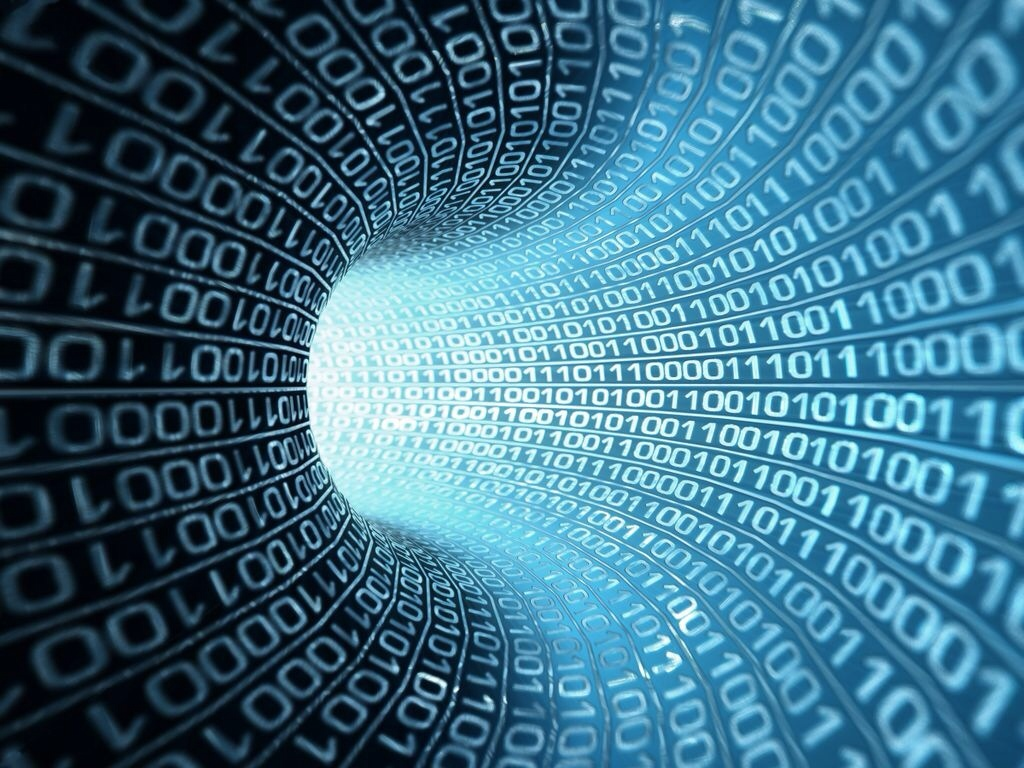

In [8]:
def build_dataframe() -> pandas:
    urls = crawl_books_urls()
    df_dict = {
        'title': [],
        'pages-count': [],
        'date-published': [],
        'bestsellers-rank': [],
        'rating': [],
        'rating-count': [],
        'author': [],
        'back-type': [],
        'price-ILS': [],
        'width': [],
        'height': [],
        'thickness': [],
        'weight': [],
        'Contemporary Fiction':[],
        "Children's Fiction": [],
        "Children's General Story Books":[],
        'Adventure Books for Kids':[],
        'Fantasy Books':[],
        'Fantasy':[],
        'Classic Books & Novels':[],
        'Fantasy Books for Kids':[],
        'Animal Stories':[],
        'Sci Fi Books for Kids':[],
        'Personal Development':[],
        'Funny Books for Kids':[],
        'Popular Psychology':[],
        'Family':[],
        'Mind':[],
        'Science Fiction':[],
        'Activity Books':[],
        'Picture Books':[],
        'Assertiveness':[],
        'Motivation & Self-esteem':[],
        'other':[]
    }
    
    for i, url in enumerate(urls):
        print('book number', i + 1)
        book_soup = get_soup_object(url)
        book = get_book_properties(book_soup)    
        for key in book:
            df_dict[key].append(book[key]) 
            
    return pandas.DataFrame(df_dict)

1 page testing

In [9]:
df = build_dataframe()

page number 1 https://www.bookdepository.com/search?searchLang=123&page=1
book number 1
book number 2
book number 3
book number 4
book number 5
book number 6
book number 7
book number 8
book number 9
book number 10
book number 11
book number 12
book number 13
book number 14
book number 15
book number 16
book number 17
book number 18
book number 19
book number 20
book number 21
book number 22
book number 23
book number 24
book number 25
book number 26
book number 27
book number 28
book number 29
book number 30


In [10]:
df.to_csv('test_crawling_n1.csv')

300 pages testing

In [12]:
df = build_dataframe()

page number 1 https://www.bookdepository.com/search?searchLang=123&page=1
page number 2 https://www.bookdepository.com/search?searchLang=123&page=2
page number 3 https://www.bookdepository.com/search?searchLang=123&page=3
page number 4 https://www.bookdepository.com/search?searchLang=123&page=4
page number 5 https://www.bookdepository.com/search?searchLang=123&page=5
page number 6 https://www.bookdepository.com/search?searchLang=123&page=6
page number 7 https://www.bookdepository.com/search?searchLang=123&page=7
page number 8 https://www.bookdepository.com/search?searchLang=123&page=8
page number 9 https://www.bookdepository.com/search?searchLang=123&page=9
page number 10 https://www.bookdepository.com/search?searchLang=123&page=10
page number 11 https://www.bookdepository.com/search?searchLang=123&page=11
page number 12 https://www.bookdepository.com/search?searchLang=123&page=12
page number 13 https://www.bookdepository.com/search?searchLang=123&page=13
page number 14 https://www.boo

page number 109 https://www.bookdepository.com/search?searchLang=123&page=109
page number 110 https://www.bookdepository.com/search?searchLang=123&page=110
page number 111 https://www.bookdepository.com/search?searchLang=123&page=111
page number 112 https://www.bookdepository.com/search?searchLang=123&page=112
page number 113 https://www.bookdepository.com/search?searchLang=123&page=113
page number 114 https://www.bookdepository.com/search?searchLang=123&page=114
page number 115 https://www.bookdepository.com/search?searchLang=123&page=115
page number 116 https://www.bookdepository.com/search?searchLang=123&page=116
page number 117 https://www.bookdepository.com/search?searchLang=123&page=117
page number 118 https://www.bookdepository.com/search?searchLang=123&page=118
page number 119 https://www.bookdepository.com/search?searchLang=123&page=119
page number 120 https://www.bookdepository.com/search?searchLang=123&page=120
page number 121 https://www.bookdepository.com/search?searchLang

page number 215 https://www.bookdepository.com/search?searchLang=123&page=215
page number 216 https://www.bookdepository.com/search?searchLang=123&page=216
page number 217 https://www.bookdepository.com/search?searchLang=123&page=217
page number 218 https://www.bookdepository.com/search?searchLang=123&page=218
page number 219 https://www.bookdepository.com/search?searchLang=123&page=219
page number 220 https://www.bookdepository.com/search?searchLang=123&page=220
page number 221 https://www.bookdepository.com/search?searchLang=123&page=221
page number 222 https://www.bookdepository.com/search?searchLang=123&page=222
page number 223 https://www.bookdepository.com/search?searchLang=123&page=223
page number 224 https://www.bookdepository.com/search?searchLang=123&page=224
page number 225 https://www.bookdepository.com/search?searchLang=123&page=225
page number 226 https://www.bookdepository.com/search?searchLang=123&page=226
page number 227 https://www.bookdepository.com/search?searchLang

book number 101
book number 102
book number 103
book number 104
book number 105
book number 106
book number 107
book number 108
book number 109
book number 110
book number 111
book number 112
book number 113
book number 114
book number 115
book number 116
book number 117
book number 118
book number 119
book number 120
book number 121
book number 122
book number 123
book number 124
book number 125
book number 126
book number 127
book number 128
book number 129
book number 130
book number 131
book number 132
book number 133
book number 134
book number 135
book number 136
book number 137
book number 138
book number 139
book number 140
book number 141
book number 142
book number 143
book number 144
book number 145
book number 146
book number 147
book number 148
book number 149
book number 150
book number 151
book number 152
book number 153
book number 154
book number 155
book number 156
book number 157
book number 158
book number 159
book number 160
book number 161
book number 162
book num

book number 614
book number 615
book number 616
book number 617
book number 618
book number 619
book number 620
book number 621
book number 622
book number 623
book number 624
book number 625
book number 626
book number 627
book number 628
book number 629
book number 630
book number 631
book number 632
book number 633
book number 634
book number 635
book number 636
book number 637
book number 638
book number 639
book number 640
book number 641
book number 642
book number 643
book number 644
book number 645
book number 646
book number 647
book number 648
book number 649
book number 650
book number 651
book number 652
book number 653
book number 654
book number 655
book number 656
book number 657
book number 658
book number 659
book number 660
book number 661
book number 662
book number 663
book number 664
book number 665
book number 666
book number 667
book number 668
book number 669
book number 670
book number 671
book number 672
book number 673
book number 674
book number 675
book num

book number 1119
book number 1120
book number 1121
book number 1122
book number 1123
book number 1124
book number 1125
book number 1126
book number 1127
book number 1128
book number 1129
book number 1130
book number 1131
book number 1132
book number 1133
book number 1134
book number 1135
book number 1136
book number 1137
book number 1138
book number 1139
book number 1140
book number 1141
book number 1142
book number 1143
book number 1144
book number 1145
book number 1146
book number 1147
book number 1148
book number 1149
book number 1150
book number 1151
book number 1152
book number 1153
book number 1154
book number 1155
book number 1156
book number 1157
book number 1158
book number 1159
book number 1160
book number 1161
book number 1162
book number 1163
book number 1164
book number 1165
book number 1166
book number 1167
book number 1168
book number 1169
book number 1170
book number 1171
book number 1172
book number 1173
book number 1174
book number 1175
book number 1176
book number 11

book number 1601
book number 1602
book number 1603
book number 1604
book number 1605
book number 1606
book number 1607
book number 1608
book number 1609
book number 1610
book number 1611
book number 1612
book number 1613
book number 1614
book number 1615
book number 1616
book number 1617
book number 1618
book number 1619
book number 1620
book number 1621
book number 1622
book number 1623
book number 1624
book number 1625
book number 1626
book number 1627
book number 1628
book number 1629
book number 1630
book number 1631
book number 1632
book number 1633
book number 1634
book number 1635
book number 1636
book number 1637
book number 1638
book number 1639
book number 1640
book number 1641
book number 1642
book number 1643
book number 1644
book number 1645
book number 1646
book number 1647
book number 1648
book number 1649
book number 1650
book number 1651
book number 1652
book number 1653
book number 1654
book number 1655
book number 1656
book number 1657
book number 1658
book number 16

book number 2083
book number 2084
book number 2085
book number 2086
book number 2087
book number 2088
book number 2089
book number 2090
book number 2091
book number 2092
book number 2093
book number 2094
book number 2095
book number 2096
book number 2097
book number 2098
book number 2099
book number 2100
book number 2101
book number 2102
book number 2103
book number 2104
book number 2105
book number 2106
book number 2107
book number 2108
book number 2109
book number 2110
book number 2111
book number 2112
book number 2113
book number 2114
book number 2115
book number 2116
book number 2117
book number 2118
book number 2119
book number 2120
book number 2121
book number 2122
book number 2123
book number 2124
book number 2125
book number 2126
book number 2127
book number 2128
book number 2129
book number 2130
book number 2131
book number 2132
book number 2133
book number 2134
book number 2135
book number 2136
book number 2137
book number 2138
book number 2139
book number 2140
book number 21

book number 2565
book number 2566
book number 2567
book number 2568
book number 2569
book number 2570
book number 2571
book number 2572
book number 2573
book number 2574
book number 2575
book number 2576
book number 2577
book number 2578
book number 2579
book number 2580
book number 2581
book number 2582
book number 2583
book number 2584
book number 2585
book number 2586
book number 2587
book number 2588
book number 2589
book number 2590
book number 2591
book number 2592
book number 2593
book number 2594
book number 2595
book number 2596
book number 2597
book number 2598
book number 2599
book number 2600
book number 2601
book number 2602
book number 2603
book number 2604
book number 2605
book number 2606
book number 2607
book number 2608
book number 2609
book number 2610
book number 2611
book number 2612
book number 2613
book number 2614
book number 2615
book number 2616
book number 2617
book number 2618
book number 2619
book number 2620
book number 2621
book number 2622
book number 26

book number 3047
book number 3048
book number 3049
book number 3050
book number 3051
book number 3052
book number 3053
book number 3054
book number 3055
book number 3056
book number 3057
book number 3058
book number 3059
book number 3060
book number 3061
book number 3062
book number 3063
book number 3064
book number 3065
book number 3066
book number 3067
book number 3068
book number 3069
book number 3070
book number 3071
book number 3072
book number 3073
book number 3074
book number 3075
book number 3076
book number 3077
book number 3078
book number 3079
book number 3080
book number 3081
book number 3082
book number 3083
book number 3084
book number 3085
book number 3086
book number 3087
book number 3088
book number 3089
book number 3090
book number 3091
book number 3092
book number 3093
book number 3094
book number 3095
book number 3096
book number 3097
book number 3098
book number 3099
book number 3100
book number 3101
book number 3102
book number 3103
book number 3104
book number 31

book number 3529
book number 3530
book number 3531
book number 3532
book number 3533
book number 3534
book number 3535
book number 3536
book number 3537
book number 3538
book number 3539
book number 3540
book number 3541
book number 3542
book number 3543
book number 3544
book number 3545
book number 3546
book number 3547
book number 3548
book number 3549
book number 3550
book number 3551
book number 3552
book number 3553
book number 3554
book number 3555
book number 3556
book number 3557
book number 3558
book number 3559
book number 3560
book number 3561
book number 3562
book number 3563
book number 3564
book number 3565
book number 3566
book number 3567
book number 3568
book number 3569
book number 3570
book number 3571
book number 3572
book number 3573
book number 3574
book number 3575
book number 3576
book number 3577
book number 3578
book number 3579
book number 3580
book number 3581
book number 3582
book number 3583
book number 3584
book number 3585
book number 3586
book number 35

book number 4011
book number 4012
book number 4013
book number 4014
book number 4015
book number 4016
book number 4017
book number 4018
book number 4019
book number 4020
book number 4021
book number 4022
book number 4023
book number 4024
book number 4025
book number 4026
book number 4027
book number 4028
book number 4029
book number 4030
book number 4031
book number 4032
book number 4033
book number 4034
book number 4035
book number 4036
book number 4037
book number 4038
book number 4039
book number 4040
book number 4041
book number 4042
book number 4043
book number 4044
book number 4045
book number 4046
book number 4047
book number 4048
book number 4049
book number 4050
book number 4051
book number 4052
book number 4053
book number 4054
book number 4055
book number 4056
book number 4057
book number 4058
book number 4059
book number 4060
book number 4061
book number 4062
book number 4063
book number 4064
book number 4065
book number 4066
book number 4067
book number 4068
book number 40

book number 4493
book number 4494
book number 4495
book number 4496
book number 4497
book number 4498
book number 4499
book number 4500
book number 4501
book number 4502
book number 4503
book number 4504
book number 4505
book number 4506
book number 4507
book number 4508
book number 4509
book number 4510
book number 4511
book number 4512
book number 4513
book number 4514
book number 4515
book number 4516
book number 4517
book number 4518
book number 4519
book number 4520
book number 4521
book number 4522
book number 4523
book number 4524
book number 4525
book number 4526
book number 4527
book number 4528
book number 4529
book number 4530
book number 4531
book number 4532
book number 4533
book number 4534
book number 4535
book number 4536
book number 4537
book number 4538
book number 4539
book number 4540
book number 4541
book number 4542
book number 4543
book number 4544
book number 4545
book number 4546
book number 4547
book number 4548
book number 4549
book number 4550
book number 45

book number 4975
book number 4976
book number 4977
book number 4978
book number 4979
book number 4980
book number 4981
book number 4982
book number 4983
book number 4984
book number 4985
book number 4986
book number 4987
book number 4988
book number 4989
book number 4990
book number 4991
book number 4992
book number 4993
book number 4994
book number 4995
book number 4996
book number 4997
book number 4998
book number 4999
book number 5000
book number 5001
book number 5002
book number 5003
book number 5004
book number 5005
book number 5006
book number 5007
book number 5008
book number 5009
book number 5010
book number 5011
book number 5012
book number 5013
book number 5014
book number 5015
book number 5016
book number 5017
book number 5018
book number 5019
book number 5020
book number 5021
book number 5022
book number 5023
book number 5024
book number 5025
book number 5026
book number 5027
book number 5028
book number 5029
book number 5030
book number 5031
book number 5032
book number 50

book number 5457
book number 5458
book number 5459
book number 5460
book number 5461
book number 5462
book number 5463
book number 5464
book number 5465
book number 5466
book number 5467
book number 5468
book number 5469
book number 5470
book number 5471
book number 5472
book number 5473
book number 5474
book number 5475
book number 5476
book number 5477
book number 5478
book number 5479
book number 5480
book number 5481
book number 5482
book number 5483
book number 5484
book number 5485
book number 5486
book number 5487
book number 5488
book number 5489
book number 5490
book number 5491
book number 5492
book number 5493
book number 5494
book number 5495
book number 5496
book number 5497
book number 5498
book number 5499
book number 5500
book number 5501
book number 5502
book number 5503
book number 5504
book number 5505
book number 5506
book number 5507
book number 5508
book number 5509
book number 5510
book number 5511
book number 5512
book number 5513
book number 5514
book number 55

book number 5939
book number 5940
book number 5941
book number 5942
book number 5943
book number 5944
book number 5945
book number 5946
book number 5947
book number 5948
book number 5949
book number 5950
book number 5951
book number 5952
book number 5953
book number 5954
book number 5955
book number 5956
book number 5957
book number 5958
book number 5959
book number 5960
book number 5961
book number 5962
book number 5963
book number 5964
book number 5965
book number 5966
book number 5967
book number 5968
book number 5969
book number 5970
book number 5971
book number 5972
book number 5973
book number 5974
book number 5975
book number 5976
book number 5977
book number 5978
book number 5979
book number 5980
book number 5981
book number 5982
book number 5983
book number 5984
book number 5985
book number 5986
book number 5987
book number 5988
book number 5989
book number 5990
book number 5991
book number 5992
book number 5993
book number 5994
book number 5995
book number 5996
book number 59

book number 6421
book number 6422
book number 6423
book number 6424
book number 6425
book number 6426
book number 6427
book number 6428
book number 6429
book number 6430
book number 6431
book number 6432
book number 6433
book number 6434
book number 6435
book number 6436
book number 6437
book number 6438
book number 6439
book number 6440
book number 6441
book number 6442
book number 6443
book number 6444
book number 6445
book number 6446
book number 6447
book number 6448
book number 6449
book number 6450
book number 6451
book number 6452
book number 6453
book number 6454
book number 6455
book number 6456
book number 6457
book number 6458
book number 6459
book number 6460
book number 6461
book number 6462
book number 6463
book number 6464
book number 6465
book number 6466
book number 6467
book number 6468
book number 6469
book number 6470
book number 6471
book number 6472
book number 6473
book number 6474
book number 6475
book number 6476
book number 6477
book number 6478
book number 64

book number 6903
book number 6904
book number 6905
book number 6906
book number 6907
book number 6908
book number 6909
book number 6910
book number 6911
book number 6912
book number 6913
book number 6914
book number 6915
book number 6916
book number 6917
book number 6918
book number 6919
book number 6920
book number 6921
book number 6922
book number 6923
book number 6924
book number 6925
book number 6926
book number 6927
book number 6928
book number 6929
book number 6930
book number 6931
book number 6932
book number 6933
book number 6934
book number 6935
book number 6936
book number 6937
book number 6938
book number 6939
book number 6940
book number 6941
book number 6942
book number 6943
book number 6944
book number 6945
book number 6946
book number 6947
book number 6948
book number 6949
book number 6950
book number 6951
book number 6952
book number 6953
book number 6954
book number 6955
book number 6956
book number 6957
book number 6958
book number 6959
book number 6960
book number 69

book number 7385
book number 7386
book number 7387
book number 7388
book number 7389
book number 7390
book number 7391
book number 7392
book number 7393
book number 7394
book number 7395
book number 7396
book number 7397
book number 7398
book number 7399
book number 7400
book number 7401
book number 7402
book number 7403
book number 7404
book number 7405
book number 7406
book number 7407
book number 7408
book number 7409
book number 7410
book number 7411
book number 7412
book number 7413
book number 7414
book number 7415
book number 7416
book number 7417
book number 7418
book number 7419
book number 7420
book number 7421
book number 7422
book number 7423
book number 7424
book number 7425
book number 7426
book number 7427
book number 7428
book number 7429
book number 7430
book number 7431
book number 7432
book number 7433
book number 7434
book number 7435
book number 7436
book number 7437
book number 7438
book number 7439
book number 7440
book number 7441
book number 7442
book number 74

book number 7867
book number 7868
book number 7869
book number 7870
book number 7871
book number 7872
book number 7873
book number 7874
book number 7875
book number 7876
book number 7877
book number 7878
book number 7879
book number 7880
book number 7881
book number 7882
book number 7883
book number 7884
book number 7885
book number 7886
book number 7887
book number 7888
book number 7889
book number 7890
book number 7891
book number 7892
book number 7893
book number 7894
book number 7895
book number 7896
book number 7897
book number 7898
book number 7899
book number 7900
book number 7901
book number 7902
book number 7903
book number 7904
book number 7905
book number 7906
book number 7907
book number 7908
book number 7909
book number 7910
book number 7911
book number 7912
book number 7913
book number 7914
book number 7915
book number 7916
book number 7917
book number 7918
book number 7919
book number 7920
book number 7921
book number 7922
book number 7923
book number 7924
book number 79

book number 8349
book number 8350
book number 8351
book number 8352
book number 8353
book number 8354
book number 8355
book number 8356
book number 8357
book number 8358
book number 8359
book number 8360
book number 8361
book number 8362
book number 8363
book number 8364
book number 8365
book number 8366
book number 8367
book number 8368
book number 8369
book number 8370
book number 8371
book number 8372
book number 8373
book number 8374
book number 8375
book number 8376
book number 8377
book number 8378
book number 8379
book number 8380
book number 8381
book number 8382
book number 8383
book number 8384
book number 8385
book number 8386
book number 8387
book number 8388
book number 8389
book number 8390
book number 8391
book number 8392
book number 8393
book number 8394
book number 8395
book number 8396
book number 8397
book number 8398
book number 8399
book number 8400
book number 8401
book number 8402
book number 8403
book number 8404
book number 8405
book number 8406
book number 84

book number 8831
book number 8832
book number 8833
book number 8834
book number 8835
book number 8836
book number 8837
book number 8838
book number 8839
book number 8840
book number 8841
book number 8842
book number 8843
book number 8844
book number 8845
book number 8846
book number 8847
book number 8848
book number 8849
book number 8850
book number 8851
book number 8852
book number 8853
book number 8854
book number 8855
book number 8856
book number 8857
book number 8858
book number 8859
book number 8860
book number 8861
book number 8862
book number 8863
book number 8864
book number 8865
book number 8866
book number 8867
book number 8868
book number 8869
book number 8870
book number 8871
book number 8872
book number 8873
book number 8874
book number 8875
book number 8876
book number 8877
book number 8878
book number 8879
book number 8880
book number 8881
book number 8882
book number 8883
book number 8884
book number 8885
book number 8886
book number 8887
book number 8888
book number 88

In [13]:
df.to_csv('main_crawling_n2.csv')

300 pages testing | Final crawling

In [9]:
df = build_dataframe()

page number 1 https://www.bookdepository.com/search?searchLang=123&page=1
page number 2 https://www.bookdepository.com/search?searchLang=123&page=2
page number 3 https://www.bookdepository.com/search?searchLang=123&page=3
page number 4 https://www.bookdepository.com/search?searchLang=123&page=4
page number 5 https://www.bookdepository.com/search?searchLang=123&page=5
page number 6 https://www.bookdepository.com/search?searchLang=123&page=6
page number 7 https://www.bookdepository.com/search?searchLang=123&page=7
page number 8 https://www.bookdepository.com/search?searchLang=123&page=8
page number 9 https://www.bookdepository.com/search?searchLang=123&page=9
page number 10 https://www.bookdepository.com/search?searchLang=123&page=10
page number 11 https://www.bookdepository.com/search?searchLang=123&page=11
page number 12 https://www.bookdepository.com/search?searchLang=123&page=12
page number 13 https://www.bookdepository.com/search?searchLang=123&page=13
page number 14 https://www.boo

page number 109 https://www.bookdepository.com/search?searchLang=123&page=109
page number 110 https://www.bookdepository.com/search?searchLang=123&page=110
page number 111 https://www.bookdepository.com/search?searchLang=123&page=111
page number 112 https://www.bookdepository.com/search?searchLang=123&page=112
page number 113 https://www.bookdepository.com/search?searchLang=123&page=113
page number 114 https://www.bookdepository.com/search?searchLang=123&page=114
page number 115 https://www.bookdepository.com/search?searchLang=123&page=115
page number 116 https://www.bookdepository.com/search?searchLang=123&page=116
page number 117 https://www.bookdepository.com/search?searchLang=123&page=117
page number 118 https://www.bookdepository.com/search?searchLang=123&page=118
page number 119 https://www.bookdepository.com/search?searchLang=123&page=119
page number 120 https://www.bookdepository.com/search?searchLang=123&page=120
page number 121 https://www.bookdepository.com/search?searchLang

page number 215 https://www.bookdepository.com/search?searchLang=123&page=215
page number 216 https://www.bookdepository.com/search?searchLang=123&page=216
page number 217 https://www.bookdepository.com/search?searchLang=123&page=217
page number 218 https://www.bookdepository.com/search?searchLang=123&page=218
page number 219 https://www.bookdepository.com/search?searchLang=123&page=219
page number 220 https://www.bookdepository.com/search?searchLang=123&page=220
page number 221 https://www.bookdepository.com/search?searchLang=123&page=221
page number 222 https://www.bookdepository.com/search?searchLang=123&page=222
page number 223 https://www.bookdepository.com/search?searchLang=123&page=223
page number 224 https://www.bookdepository.com/search?searchLang=123&page=224
page number 225 https://www.bookdepository.com/search?searchLang=123&page=225
page number 226 https://www.bookdepository.com/search?searchLang=123&page=226
page number 227 https://www.bookdepository.com/search?searchLang

book number 101
book number 102
book number 103
book number 104
book number 105
book number 106
book number 107
book number 108
book number 109
book number 110
book number 111
book number 112
book number 113
book number 114
book number 115
book number 116
book number 117
book number 118
book number 119
book number 120
book number 121
book number 122
book number 123
book number 124
book number 125
book number 126
book number 127
book number 128
book number 129
book number 130
book number 131
book number 132
book number 133
book number 134
book number 135
book number 136
book number 137
book number 138
book number 139
book number 140
book number 141
book number 142
book number 143
book number 144
book number 145
book number 146
book number 147
book number 148
book number 149
book number 150
book number 151
book number 152
book number 153
book number 154
book number 155
book number 156
book number 157
book number 158
book number 159
book number 160
book number 161
book number 162
book num

book number 614
book number 615
book number 616
book number 617
book number 618
book number 619
book number 620
book number 621
book number 622
book number 623
book number 624
book number 625
book number 626
book number 627
book number 628
book number 629
book number 630
book number 631
book number 632
book number 633
book number 634
book number 635
book number 636
book number 637
book number 638
book number 639
book number 640
book number 641
book number 642
book number 643
book number 644
book number 645
book number 646
book number 647
book number 648
book number 649
book number 650
book number 651
book number 652
book number 653
book number 654
book number 655
book number 656
book number 657
book number 658
book number 659
book number 660
book number 661
book number 662
book number 663
book number 664
book number 665
book number 666
book number 667
book number 668
book number 669
book number 670
book number 671
book number 672
book number 673
book number 674
book number 675
book num

book number 1119
book number 1120
book number 1121
book number 1122
book number 1123
book number 1124
book number 1125
book number 1126
book number 1127
book number 1128
book number 1129
book number 1130
book number 1131
book number 1132
book number 1133
book number 1134
book number 1135
book number 1136
book number 1137
book number 1138
book number 1139
book number 1140
book number 1141
book number 1142
book number 1143
book number 1144
book number 1145
book number 1146
book number 1147
book number 1148
book number 1149
book number 1150
book number 1151
book number 1152
book number 1153
book number 1154
book number 1155
book number 1156
book number 1157
book number 1158
book number 1159
book number 1160
book number 1161
book number 1162
book number 1163
book number 1164
book number 1165
book number 1166
book number 1167
book number 1168
book number 1169
book number 1170
book number 1171
book number 1172
book number 1173
book number 1174
book number 1175
book number 1176
book number 11

book number 1601
book number 1602
book number 1603
book number 1604
book number 1605
book number 1606
book number 1607
book number 1608
book number 1609
book number 1610
book number 1611
book number 1612
book number 1613
book number 1614
book number 1615
book number 1616
book number 1617
book number 1618
book number 1619
book number 1620
book number 1621
book number 1622
book number 1623
book number 1624
book number 1625
book number 1626
book number 1627
book number 1628
book number 1629
book number 1630
book number 1631
book number 1632
book number 1633
book number 1634
book number 1635
book number 1636
book number 1637
book number 1638
book number 1639
book number 1640
book number 1641
book number 1642
book number 1643
book number 1644
book number 1645
book number 1646
book number 1647
book number 1648
book number 1649
book number 1650
book number 1651
book number 1652
book number 1653
book number 1654
book number 1655
book number 1656
book number 1657
book number 1658
book number 16

book number 2083
book number 2084
book number 2085
book number 2086
book number 2087
book number 2088
book number 2089
book number 2090
book number 2091
book number 2092
book number 2093
book number 2094
book number 2095
book number 2096
book number 2097
book number 2098
book number 2099
book number 2100
book number 2101
book number 2102
book number 2103
book number 2104
book number 2105
book number 2106
book number 2107
book number 2108
book number 2109
book number 2110
book number 2111
book number 2112
book number 2113
book number 2114
book number 2115
book number 2116
book number 2117
book number 2118
book number 2119
book number 2120
book number 2121
book number 2122
book number 2123
book number 2124
book number 2125
book number 2126
book number 2127
book number 2128
book number 2129
book number 2130
book number 2131
book number 2132
book number 2133
book number 2134
book number 2135
book number 2136
book number 2137
book number 2138
book number 2139
book number 2140
book number 21

book number 2565
book number 2566
book number 2567
book number 2568
book number 2569
book number 2570
book number 2571
book number 2572
book number 2573
book number 2574
book number 2575
book number 2576
book number 2577
book number 2578
book number 2579
book number 2580
book number 2581
book number 2582
book number 2583
book number 2584
book number 2585
book number 2586
book number 2587
book number 2588
book number 2589
book number 2590
book number 2591
book number 2592
book number 2593
book number 2594
book number 2595
book number 2596
book number 2597
book number 2598
book number 2599
book number 2600
book number 2601
book number 2602
book number 2603
book number 2604
book number 2605
book number 2606
book number 2607
book number 2608
book number 2609
book number 2610
book number 2611
book number 2612
book number 2613
book number 2614
book number 2615
book number 2616
book number 2617
book number 2618
book number 2619
book number 2620
book number 2621
book number 2622
book number 26

book number 3047
book number 3048
book number 3049
book number 3050
book number 3051
book number 3052
book number 3053
book number 3054
book number 3055
book number 3056
book number 3057
book number 3058
book number 3059
book number 3060
book number 3061
book number 3062
book number 3063
book number 3064
book number 3065
book number 3066
book number 3067
book number 3068
book number 3069
book number 3070
book number 3071
book number 3072
book number 3073
book number 3074
book number 3075
book number 3076
book number 3077
book number 3078
book number 3079
book number 3080
book number 3081
book number 3082
book number 3083
book number 3084
book number 3085
book number 3086
book number 3087
book number 3088
book number 3089
book number 3090
book number 3091
book number 3092
book number 3093
book number 3094
book number 3095
book number 3096
book number 3097
book number 3098
book number 3099
book number 3100
book number 3101
book number 3102
book number 3103
book number 3104
book number 31

book number 3529
book number 3530
book number 3531
book number 3532
book number 3533
book number 3534
book number 3535
book number 3536
book number 3537
book number 3538
book number 3539
book number 3540
book number 3541
book number 3542
book number 3543
book number 3544
book number 3545
book number 3546
book number 3547
book number 3548
book number 3549
book number 3550
book number 3551
book number 3552
book number 3553
book number 3554
book number 3555
book number 3556
book number 3557
book number 3558
book number 3559
book number 3560
book number 3561
book number 3562
book number 3563
book number 3564
book number 3565
book number 3566
book number 3567
book number 3568
book number 3569
book number 3570
book number 3571
book number 3572
book number 3573
book number 3574
book number 3575
book number 3576
book number 3577
book number 3578
book number 3579
book number 3580
book number 3581
book number 3582
book number 3583
book number 3584
book number 3585
book number 3586
book number 35

book number 4011
book number 4012
book number 4013
book number 4014
book number 4015
book number 4016
book number 4017
book number 4018
book number 4019
book number 4020
book number 4021
book number 4022
book number 4023
book number 4024
book number 4025
book number 4026
book number 4027
book number 4028
book number 4029
book number 4030
book number 4031
book number 4032
book number 4033
book number 4034
book number 4035
book number 4036
book number 4037
book number 4038
book number 4039
book number 4040
book number 4041
book number 4042
book number 4043
book number 4044
book number 4045
book number 4046
book number 4047
book number 4048
book number 4049
book number 4050
book number 4051
book number 4052
book number 4053
book number 4054
book number 4055
book number 4056
book number 4057
book number 4058
book number 4059
book number 4060
book number 4061
book number 4062
book number 4063
book number 4064
book number 4065
book number 4066
book number 4067
book number 4068
book number 40

book number 4493
book number 4494
book number 4495
book number 4496
book number 4497
book number 4498
book number 4499
book number 4500
book number 4501
book number 4502
book number 4503
book number 4504
book number 4505
book number 4506
book number 4507
book number 4508
book number 4509
book number 4510
book number 4511
book number 4512
book number 4513
book number 4514
book number 4515
book number 4516
book number 4517
book number 4518
book number 4519
book number 4520
book number 4521
book number 4522
book number 4523
book number 4524
book number 4525
book number 4526
book number 4527
book number 4528
book number 4529
book number 4530
book number 4531
book number 4532
book number 4533
book number 4534
book number 4535
book number 4536
book number 4537
book number 4538
book number 4539
book number 4540
book number 4541
book number 4542
book number 4543
book number 4544
book number 4545
book number 4546
book number 4547
book number 4548
book number 4549
book number 4550
book number 45

book number 4975
book number 4976
book number 4977
book number 4978
book number 4979
book number 4980
book number 4981
book number 4982
book number 4983
book number 4984
book number 4985
book number 4986
book number 4987
book number 4988
book number 4989
book number 4990
book number 4991
book number 4992
book number 4993
book number 4994
book number 4995
book number 4996
book number 4997
book number 4998
book number 4999
book number 5000
book number 5001
book number 5002
book number 5003
book number 5004
book number 5005
book number 5006
book number 5007
book number 5008
book number 5009
book number 5010
book number 5011
book number 5012
book number 5013
book number 5014
book number 5015
book number 5016
book number 5017
book number 5018
book number 5019
book number 5020
book number 5021
book number 5022
book number 5023
book number 5024
book number 5025
book number 5026
book number 5027
book number 5028
book number 5029
book number 5030
book number 5031
book number 5032
book number 50

book number 5457
book number 5458
book number 5459
book number 5460
book number 5461
book number 5462
book number 5463
book number 5464
book number 5465
book number 5466
book number 5467
book number 5468
book number 5469
book number 5470
book number 5471
book number 5472
book number 5473
book number 5474
book number 5475
book number 5476
book number 5477
book number 5478
book number 5479
book number 5480
book number 5481
book number 5482
book number 5483
book number 5484
book number 5485
book number 5486
book number 5487
book number 5488
book number 5489
book number 5490
book number 5491
book number 5492
book number 5493
book number 5494
book number 5495
book number 5496
book number 5497
book number 5498
book number 5499
book number 5500
book number 5501
book number 5502
book number 5503
book number 5504
book number 5505
book number 5506
book number 5507
book number 5508
book number 5509
book number 5510
book number 5511
book number 5512
book number 5513
book number 5514
book number 55

book number 5939
book number 5940
book number 5941
book number 5942
book number 5943
book number 5944
book number 5945
book number 5946
book number 5947
book number 5948
book number 5949
book number 5950
book number 5951
book number 5952
book number 5953
book number 5954
book number 5955
book number 5956
book number 5957
book number 5958
book number 5959
book number 5960
book number 5961
book number 5962
book number 5963
book number 5964
book number 5965
book number 5966
book number 5967
book number 5968
book number 5969
book number 5970
book number 5971
book number 5972
book number 5973
book number 5974
book number 5975
book number 5976
book number 5977
book number 5978
book number 5979
book number 5980
book number 5981
book number 5982
book number 5983
book number 5984
book number 5985
book number 5986
book number 5987
book number 5988
book number 5989
book number 5990
book number 5991
book number 5992
book number 5993
book number 5994
book number 5995
book number 5996
book number 59

book number 6421
book number 6422
book number 6423
book number 6424
book number 6425
book number 6426
book number 6427
book number 6428
book number 6429
book number 6430
book number 6431
book number 6432
book number 6433
book number 6434
book number 6435
book number 6436
book number 6437
book number 6438
book number 6439
book number 6440
book number 6441
book number 6442
book number 6443
book number 6444
book number 6445
book number 6446
book number 6447
book number 6448
book number 6449
book number 6450
book number 6451
book number 6452
book number 6453
book number 6454
book number 6455
book number 6456
book number 6457
book number 6458
book number 6459
book number 6460
book number 6461
book number 6462
book number 6463
book number 6464
book number 6465
book number 6466
book number 6467
book number 6468
book number 6469
book number 6470
book number 6471
book number 6472
book number 6473
book number 6474
book number 6475
book number 6476
book number 6477
book number 6478
book number 64

book number 6903
book number 6904
book number 6905
book number 6906
book number 6907
book number 6908
book number 6909
book number 6910
book number 6911
book number 6912
book number 6913
book number 6914
book number 6915
book number 6916
book number 6917
book number 6918
book number 6919
book number 6920
book number 6921
book number 6922
book number 6923
book number 6924
book number 6925
book number 6926
book number 6927
book number 6928
book number 6929
book number 6930
book number 6931
book number 6932
book number 6933
book number 6934
book number 6935
book number 6936
book number 6937
book number 6938
book number 6939
book number 6940
book number 6941
book number 6942
book number 6943
book number 6944
book number 6945
book number 6946
book number 6947
book number 6948
book number 6949
book number 6950
book number 6951
book number 6952
book number 6953
book number 6954
book number 6955
book number 6956
book number 6957
book number 6958
book number 6959
book number 6960
book number 69

book number 7385
book number 7386
book number 7387
book number 7388
book number 7389
book number 7390
book number 7391
book number 7392
book number 7393
book number 7394
book number 7395
book number 7396
book number 7397
book number 7398
book number 7399
book number 7400
book number 7401
book number 7402
book number 7403
book number 7404
book number 7405
book number 7406
book number 7407
book number 7408
book number 7409
book number 7410
book number 7411
book number 7412
book number 7413
book number 7414
book number 7415
book number 7416
book number 7417
book number 7418
book number 7419
book number 7420
book number 7421
book number 7422
book number 7423
book number 7424
book number 7425
book number 7426
book number 7427
book number 7428
book number 7429
book number 7430
book number 7431
book number 7432
book number 7433
book number 7434
book number 7435
book number 7436
book number 7437
book number 7438
book number 7439
book number 7440
book number 7441
book number 7442
book number 74

book number 7867
book number 7868
book number 7869
book number 7870
book number 7871
book number 7872
book number 7873
book number 7874
book number 7875
book number 7876
book number 7877
book number 7878
book number 7879
book number 7880
book number 7881
book number 7882
book number 7883
book number 7884
book number 7885
book number 7886
book number 7887
book number 7888
book number 7889
book number 7890
book number 7891
book number 7892
book number 7893
book number 7894
book number 7895
book number 7896
book number 7897
book number 7898
book number 7899
book number 7900
book number 7901
book number 7902
book number 7903
book number 7904
book number 7905
book number 7906
book number 7907
book number 7908
book number 7909
book number 7910
book number 7911
book number 7912
book number 7913
book number 7914
book number 7915
book number 7916
book number 7917
book number 7918
book number 7919
book number 7920
book number 7921
book number 7922
book number 7923
book number 7924
book number 79

book number 8349
book number 8350
book number 8351
book number 8352
book number 8353
book number 8354
book number 8355
book number 8356
book number 8357
book number 8358
book number 8359
book number 8360
book number 8361
book number 8362
book number 8363
book number 8364
book number 8365
book number 8366
book number 8367
book number 8368
book number 8369
book number 8370
book number 8371
book number 8372
book number 8373
book number 8374
book number 8375
book number 8376
book number 8377
book number 8378
book number 8379
book number 8380
book number 8381
book number 8382
book number 8383
book number 8384
book number 8385
book number 8386
book number 8387
book number 8388
book number 8389
book number 8390
book number 8391
book number 8392
book number 8393
book number 8394
book number 8395
book number 8396
book number 8397
book number 8398
book number 8399
book number 8400
book number 8401
book number 8402
book number 8403
book number 8404
book number 8405
book number 8406
book number 84

book number 8831
book number 8832
book number 8833
book number 8834
book number 8835
book number 8836
book number 8837
book number 8838
book number 8839
book number 8840
book number 8841
book number 8842
book number 8843
book number 8844
book number 8845
book number 8846
book number 8847
book number 8848
book number 8849
book number 8850
book number 8851
book number 8852
book number 8853
book number 8854
book number 8855
book number 8856
book number 8857
book number 8858
book number 8859
book number 8860
book number 8861
book number 8862
book number 8863
book number 8864
book number 8865
book number 8866
book number 8867
book number 8868
book number 8869
book number 8870
book number 8871
book number 8872
book number 8873
book number 8874
book number 8875
book number 8876
book number 8877
book number 8878
book number 8879
book number 8880
book number 8881
book number 8882
book number 8883
book number 8884
book number 8885
book number 8886
book number 8887
book number 8888
book number 88

In [10]:
df.to_csv('final_df.csv')